В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import opendatasets as od
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

In [3]:
dataset_url = "https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2"
# od.download(dataset_url)


In [4]:
raw_df = pd.read_csv("bank-customer-churn-prediction-dlu-course-c-2/train.csv")
raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.0,Ch'iu,585.0,France,Male,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0
14996,14996,15731781.0,Ch'ang,678.0,France,Male,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0
14997,14997,15667093.0,Goliwe,678.0,France,Female,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0
14998,14998,15732644.0,Fanucci,705.0,Spain,Female,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [5]:
# CustomerId не корисний, так як це просто рандомний номер
input_cols = raw_df.columns[2:-1].tolist()
target_col = 'Exited'

X = raw_df[input_cols].copy()
y = raw_df[target_col].copy()

train_inputs, val_inputs, train_targets, val_targets = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [6]:
numeric_cols = train_inputs.select_dtypes('number').columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [7]:
train_inputs[numeric_cols].isnull().sum()
# Пропущених значень немає, а отже імпутування не потрібне.

CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [8]:
train_inputs[numeric_cols].describe().round(2)
# Числові стовпці в нашому наборі даних мають різні діапазони, тому потрібне масштабування.

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00
mean,658.99,37.69,5.02,42952.89,1.59,0.79,0.49,117904.96
std,72.12,8.14,2.78,59923.39,0.53,0.41,0.50,45553.03
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83155.87
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123587.94
75%,709.00,42.00,7.00,109863.19,2.00,1.00,1.00,156774.94
max,850.00,72.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [9]:
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [14]:
train_inputs[categorical_cols].nunique()
# Категорію Gender можна закодувати 0/1 так як тільки 2 значення.
# Для Geography застосувати OneHotEncoder.
# Surname з точки зору логіки не несе якоїсь користі, тому можна його видалити.
categorical_cols = ['Geography']

Geography    3
dtype: int64

In [11]:
train_inputs['Gender'] = train_inputs['Gender'].apply(lambda x: 0 if x == "Male" else 1)
val_inputs['Gender'] = val_inputs['Gender'].apply(lambda x: 0 if x == "Male" else 1)

In [12]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols])

encoded_cols = encoder.get_feature_names_out(categorical_cols).tolist()

train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

display(train_inputs.head(5))
display(val_inputs.head(5))

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
8263,Toscani,0.632458,France,0,0.259259,0.5,0.622726,0.000000,1.0,1.0,0.433916,1.0,0.0,0.0
14199,Kuo,0.479714,Germany,1,0.259259,0.4,0.571232,0.000000,1.0,0.0,0.888712,0.0,1.0,0.0
1856,Ejimofor,0.591885,France,1,0.074074,0.4,0.000000,0.333333,1.0,1.0,0.813017,1.0,0.0,0.0
3013,Onochie,0.653938,France,0,0.555556,0.3,0.000000,0.333333,1.0,0.0,0.599071,1.0,0.0,0.0
8266,Chukwuemeka,0.632458,France,1,0.314815,0.7,0.000000,0.333333,1.0,0.0,0.502109,1.0,0.0,0.0


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
1855,Bitter,0.267303,France,0,0.203704,0.9,0.570579,0.0,0.0,0.0,0.279047,1.0,0.0,0.0
1273,Ting,0.398568,Germany,0,0.425926,0.3,0.590481,0.0,1.0,0.0,0.884371,0.0,1.0,0.0
5414,Maclean,0.453461,France,0,0.240741,0.7,0.000000,0.0,1.0,1.0,0.751226,1.0,0.0,0.0
10923,Chiang,0.396181,France,0,0.703704,0.3,0.000000,1.0,1.0,0.0,0.514675,1.0,0.0,0.0
5835,Oluchi,0.758950,Spain,1,0.444444,0.5,0.000000,0.0,1.0,1.0,0.909003,0.0,0.0,1.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [13]:
train_inputs.to_parquet("bank-customer-churn-prediction-dlu-course-c-2/train_inputs.parquet")
val_inputs.to_parquet("bank-customer-churn-prediction-dlu-course-c-2/val_inputs.parquet")

pd.DataFrame(train_targets).to_parquet("bank-customer-churn-prediction-dlu-course-c-2/train_targets.parquet")
pd.DataFrame(val_targets).to_parquet("bank-customer-churn-prediction-dlu-course-c-2/val_targets.parquet")

os.listdir("bank-customer-churn-prediction-dlu-course-c-2")

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

6. З підготовлених вхідних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [1939]:
X_train = train_inputs.select_dtypes('number')
X_val = val_inputs.select_dtypes('number')

model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [1940]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

train_probs = model.predict_proba(X_train)
val_probs = model.predict_proba(X_val)

In [1941]:
# Confusion matrix
train_cm = confusion_matrix(train_targets, train_preds)
val_cm = confusion_matrix(val_targets, val_preds)

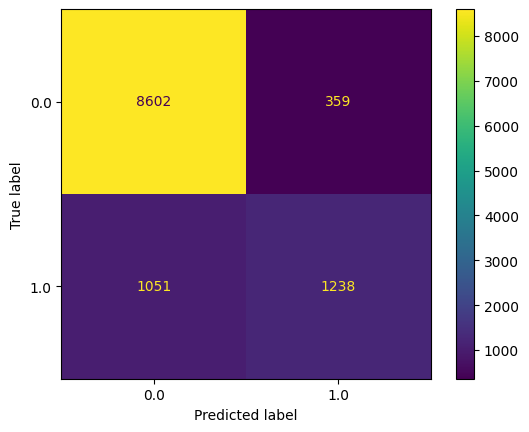

In [1942]:
train_cm_plt = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=model.classes_)
train_cm_plt.plot()

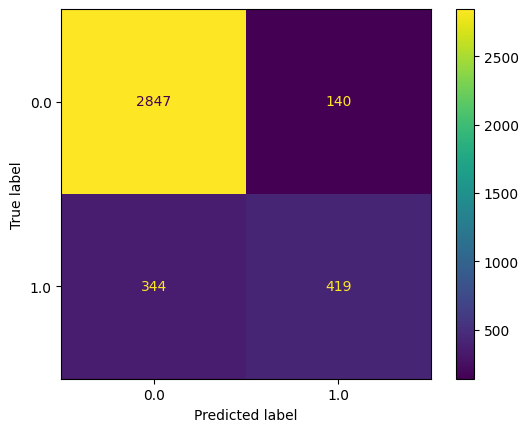

In [1943]:
val_cm_plt = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=model.classes_)
val_cm_plt.plot()

In [1944]:
# ROC curve
train_fpr, train_tpr, train_trashhold = roc_curve(train_targets, train_probs[:, 1])
val_fpr, val_tpr, val_trashhold = roc_curve(val_targets, val_probs[:, 1])

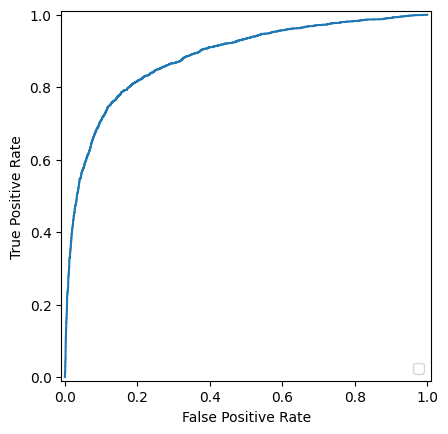

In [1945]:
train_roc_plt = RocCurveDisplay(fpr=train_fpr, tpr=train_tpr)
train_roc_plt.plot()

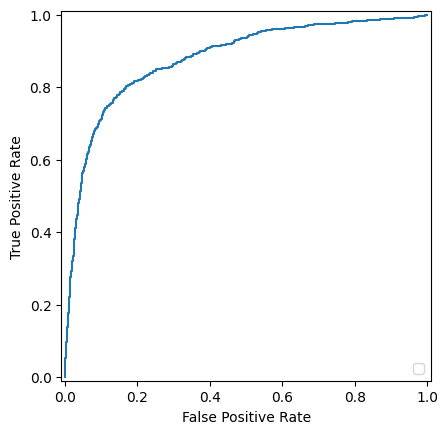

In [1946]:
val_roc_plt = RocCurveDisplay(fpr=val_fpr, tpr=val_tpr)
val_roc_plt.plot()

In [1947]:
# AUROC
train_auroc = roc_auc_score(train_targets, train_probs[:, 1])
val_auroc = roc_auc_score(val_targets, val_probs[:, 1])

train_auroc, val_auroc

(np.float64(0.8825862997702436), np.float64(0.8798616635389441))

In [1948]:
# F1 score at 0.5 trashhold
train_f1 = f1_score(train_targets, train_preds)
val_f1 = f1_score(val_targets, val_preds)

train_f1, val_f1

(0.6371590324240864, 0.6338880484114977)

In [1949]:
print(classification_report(train_targets, train_preds))

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      8961
         1.0       0.78      0.54      0.64      2289

    accuracy                           0.87     11250
   macro avg       0.83      0.75      0.78     11250
weighted avg       0.87      0.87      0.87     11250



In [1950]:
print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      2987
         1.0       0.75      0.55      0.63       763

    accuracy                           0.87      3750
   macro avg       0.82      0.75      0.78      3750
weighted avg       0.86      0.87      0.86      3750



**Висновок**

Модель досить не погана. Я б сказав на даному етапі задовільна.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [1951]:
def dummy_model(inputs):
    return np.full(len(inputs), 0)

In [1952]:
train_acu = accuracy_score(train_targets, train_preds)
val_acu = accuracy_score(val_targets, val_preds)

dummy_train_acu = accuracy_score(train_targets, dummy_model(X_train))
dummy_val_acu = accuracy_score(val_targets, dummy_model(X_val))

print(f"Model accuracy on training data: {train_acu}")
print(f"Model accuracy on validation data: {val_acu}")
print(f"Dummy model accuracy on training data: {dummy_train_acu}")
print(f"Dummy model accuracy on validation data: {dummy_val_acu}")

Model accuracy on training data: 0.8746666666666667
Model accuracy on validation data: 0.8709333333333333
Dummy model accuracy on training data: 0.7965333333333333
Dummy model accuracy on validation data: 0.7965333333333333


**Висновок**

Точність справжньої моделі краща ніж мажоритарної. Модель не погана, як мінімум тому, що точність одинакова і на тестових даних, які модель не бачила.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [1953]:
bank_customer = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(bank_customer, "bank-customer-churn-prediction-dlu-course-c-2/bank_customer.joblib")

['bank-customer-churn-prediction-dlu-course-c-2/bank_customer.joblib']

In [1954]:
model_2 = joblib.load("bank-customer-churn-prediction-dlu-course-c-2/bank_customer.joblib")

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [1955]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df = input_df[input_df.columns[2:]]
    input_df['Gender'] = input_df['Gender'].apply(lambda x: 0 if x == "Male" else 1)
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df.select_dtypes('number')
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [1956]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df.drop(columns=['Exited'])[:5])

array([0.00643812, 0.0372584 , 0.36769884, 0.37600607, 0.97576681])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [1957]:
test_raw_df = pd.read_csv("bank-customer-churn-prediction-dlu-course-c-2/test.csv")
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df).round(2)

test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.08
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.04
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.15
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.20
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65,0.02
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50,0.03
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72,0.02
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09,0.15


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [1958]:
sample_raw_df = pd.read_csv("bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv")
sample_raw_df = sample_raw_df.merge(test_raw_df[['id', 'Exited']], on='id', how='left')
sample_raw_df['Exited'] = sample_raw_df['Exited_y']
sample_raw_df.drop(columns=['Exited_y', 'Exited_x'], inplace=True)
sample_raw_df.head(5)

,id,Exited
0,15000,0.08
1,15001,0.04
2,15002,0.15
3,15003,0.20
4,15004,0.06


In [1959]:
sample_raw_df.to_csv("bank-customer-churn-prediction-dlu-course-c-2/submission_log_reg.csv", index=False)